## This notebook contains ALL 8 matching methods:

### String Distance Methods (Cohen et al.):
1. **Jaro-Winkler** - Character-level similarity with prefix boost
2. **Levenshtein** - Edit distance (insertions, deletions, substitutions)
3. **Monge-Elkan** - Token-level matching with Jaro-Winkler base

### Token-Based Methods (Cohen et al.):
4. **TF-IDF** - Traditional cosine similarity on term frequency vectors
5. **Soft-TFIDF** - Fuzzy TF-IDF with approximate token matching (θ=0.9)

### Embedding Methods:
6. **SentenceTransformer** - Local embeddings (all-MiniLM-L6-v2)
7. **OpenAI Embeddings** - API embeddings (text-embedding-3-small)

### LLM Method:
8. **GPT-4o-mini** - LLM-based matching with blocking strategy

## Installation & Setup

In [2]:
!pip install jellyfish py_stringmatching sentence-transformers openai tqdm scikit-learn python-dotenv


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [1]:
# 📚 IMPORTS
import pandas as pd
import numpy as np
import time
import os
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# String matching
import jellyfish
import py_stringmatching as sm

# TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Embeddings
from sentence_transformers import SentenceTransformer

# OpenAI
from openai import OpenAI
from dotenv import load_dotenv

# Display
from IPython.display import display

print("Libraries Imported Successfully!")

Libraries Imported Successfully!


## Configuration

- **TEST_MODE = True**: Uses only 100 records 
- **TEST_MODE = False**: Uses full dataset

In [4]:
# TEST MODE: Set to True for quick test (100 records)
TEST_MODE = False  # 

# Dataset selection
DATASET_NAME = 'abt-buy'  # Options: 'abt-buy', 'amazon-google', 'dblp-acm', 'dblp-scholar'


CONFIG = {
    'dataset_name': DATASET_NAME,
    
    # Abt-Buy paths (using ../ to go up from notebooks/ folder)
    'dataset_a': '../data/abt-buy/Abt.csv',
    'dataset_b': '../data/abt-buy/Buy.csv',
    'dataset_a_ciphered': '../data/abt-buy/Abt_ciphered.csv',
    'dataset_b_ciphered': '../data/abt-buy/Buy_ciphered.csv',
    'dataset_a_scrambled': '../data/abt-buy/Abt_scrambled.csv',
    'dataset_b_scrambled': '../data/abt-buy/Buy_scrambled.csv',
    'ground_truth': '../data/abt-buy/abt_buy_perfectMapping.csv',
    
    # Column names for Abt-Buy
    'id_col_a': 'id',
    'id_col_b': 'id',
    'text_cols': ['name', 'description'],
    'gt_col_a': 'idAbt',
    'gt_col_b': 'idBuy',
}

# Amazon-Google:
# CONFIG['text_cols'] = ['title', 'description', 'manufacturer']
# CONFIG['gt_col_a'] = 'idAmazon'
# CONFIG['gt_col_b'] = 'idGoogleProducts'

# DBLP-ACM or DBLP-Scholar:
# CONFIG['text_cols'] = ['title', 'authors', 'venue']
# CONFIG['gt_col_a'] = 'idDBLP'
# CONFIG['gt_col_b'] = 'idACM'  # or 'idScholar'


# OpenAI API Key
load_dotenv()
OPENAI_API_KEY = os.getenv('OPENAI_API_KEY')

if OPENAI_API_KEY:
    client = OpenAI(api_key=OPENAI_API_KEY)
    print("OpenAI API key loaded")
else:
    print("No OpenAI API key - OpenAI methods will be skipped")

# Display Settings
print("\n" + "="*60)
if TEST_MODE:
    print("TEST MODE ENABLED")
    print("- Using only 100 records per dataset")
else:
    print("FULL MODE ENABLED")
    print("- Using complete datasets")
print("="*60)
print(f"Dataset: {CONFIG['dataset_name']}")
print("="*60)

OpenAI API key loaded

FULL MODE ENABLED
- Using complete datasets
Dataset: abt-buy


## Load Data

In [5]:
def load_csv_with_encoding(filepath):
    """
    Load CSV with automatic encoding detection.
    Tries UTF-8, Latin-1, Windows-1252, and ISO-8859-1.
    """
    encodings = ['utf-8', 'latin-1', 'windows-1252', 'iso-8859-1']
    
    for encoding in encodings:
        try:
            df = pd.read_csv(filepath, encoding=encoding)
            print(f"   Loaded with {encoding} encoding")
            return df
        except (UnicodeDecodeError, UnicodeError):
            continue
    
    # If all fail, raise error
    raise ValueError(f"Could not read {filepath} with any encoding: {encodings}")

print("Loading datasets with auto-encoding detection...\n")

try:
    # Load original datasets
    print("Loading Original Dataset A...")
    df_a = load_csv_with_encoding(CONFIG['dataset_a'])
    print(f"Dataset A: {len(df_a):,} records\n")
    
    print("Loading Original Dataset B...")
    df_b = load_csv_with_encoding(CONFIG['dataset_b'])
    print(f"Dataset B: {len(df_b):,} records\n")
    
    # Load ciphered datasets
    print("Loading Ciphered Dataset A...")
    df_a_ciphered = load_csv_with_encoding(CONFIG['dataset_a_ciphered'])
    print(f"Ciphered A: {len(df_a_ciphered):,} records\n")
    
    print("Loading Ciphered Dataset B...")
    df_b_ciphered = load_csv_with_encoding(CONFIG['dataset_b_ciphered'])
    print(f"Ciphered B: {len(df_b_ciphered):,} records\n")
    
    # Load scrambled datasets
    print("Loading Scrambled Dataset A...")
    df_a_scrambled = load_csv_with_encoding(CONFIG['dataset_a_scrambled'])
    print(f"Scrambled A: {len(df_a_scrambled):,} records\n")
    
    print("Loading Scrambled Dataset B...")
    df_b_scrambled = load_csv_with_encoding(CONFIG['dataset_b_scrambled'])
    print(f"Scrambled B: {len(df_b_scrambled):,} records\n")
    
    # Load ground truth
    print("Loading Ground Truth...")
    ground_truth = load_csv_with_encoding(CONFIG['ground_truth'])
    print(f"\nGround Truth: {len(ground_truth):,} known matches")
    
except FileNotFoundError as e:
    print(f"\nERROR: Could not find file!")  
    raise

# ============================================
# APPLY TEST MODE
# ============================================

if TEST_MODE:
    print("\n" + "="*60)
    print("TEST MODE: Reducing to 100 records per dataset")
    print("="*60)
    
    df_a = df_a.head(100)
    df_b = df_b.head(100)
    df_a_ciphered = df_a_ciphered.head(100)
    df_b_ciphered = df_b_ciphered.head(100)
    df_a_scrambled = df_a_scrambled.head(100)
    df_b_scrambled = df_b_scrambled.head(100)
    
    print(f" Reduced to {len(df_a)} × {len(df_b)} = {len(df_a) * len(df_b):,} comparisons")
    print(f"   (Original would be {1081 * 1092:,} comparisons)")
    print("="*60)

# Preview
print("\nData Preview:")
display(df_a.head(3))

Loading datasets with auto-encoding detection...

Loading Original Dataset A...
   Loaded with latin-1 encoding
Dataset A: 1,081 records

Loading Original Dataset B...
   Loaded with utf-8 encoding
Dataset B: 1,092 records

Loading Ciphered Dataset A...
   Loaded with latin-1 encoding
Ciphered A: 1,081 records

Loading Ciphered Dataset B...
   Loaded with utf-8 encoding
Ciphered B: 1,092 records

Loading Scrambled Dataset A...
   Loaded with latin-1 encoding
Scrambled A: 1,081 records

Loading Scrambled Dataset B...
   Loaded with utf-8 encoding
Scrambled B: 1,092 records

Loading Ground Truth...
   Loaded with utf-8 encoding

Ground Truth: 1,097 known matches

Data Preview:


,id,name,description,price
0,552,Sony Turntable - PSLX350H,Sony Turntable - PSLX350H/ Belt Drive System/ ...,NaN
1,580,Bose Acoustimass 5 Series III Speaker System -...,Bose Acoustimass 5 Series III Speaker System -...,$399.00
2,4696,Sony Switcher - SBV40S,Sony Switcher - SBV40S/ Eliminates Disconnecti...,$49.00


## Text Preprocessing

In [8]:
""" 
1. Handle missing values
2. Convert to lowercase
3. Combine multiple columns into one 'text' column
"""

def preprocess_text(df, text_columns):
    """
    Preprocess text for matching.
    """
    for col in text_columns:
        df[col] = df[col].fillna('')
    
    df['text'] = df[text_columns].apply(
        lambda row: ' '.join(row.values.astype(str)).lower().strip(),
        axis=1
    )
    
    return df

print("Preprocessing...\n")

df_a = preprocess_text(df_a, CONFIG['text_cols'])
df_b = preprocess_text(df_b, CONFIG['text_cols'])
df_a_ciphered = preprocess_text(df_a_ciphered, CONFIG['text_cols'])
df_b_ciphered = preprocess_text(df_b_ciphered, CONFIG['text_cols'])
df_a_scrambled = preprocess_text(df_a_scrambled, CONFIG['text_cols'])
df_b_scrambled = preprocess_text(df_b_scrambled, CONFIG['text_cols'])

print("All datasets preprocessed")

Preprocessing...

All datasets preprocessed


## Build Ground Truth Set

In [9]:
true_matches = set(
    zip(
        ground_truth[CONFIG['gt_col_a']].astype(str),
        ground_truth[CONFIG['gt_col_b']].astype(str)
    )
)

print(f"Ground truth: {len(true_matches):,} true matches")

Ground truth: 1,097 true matches


## Implementing Matching Methods

In [13]:
# ==================================================
# METHOD 1: Jaro-Winkler
# ==================================================

def jaro_winkler_similarity(str1, str2):
    """Character-level similarity with prefix boost."""
    return jellyfish.jaro_winkler_similarity(str1, str2)

print("Jaro-Winkler ready")

# ==================================================
# METHOD 2: Levenshtein
# ==================================================

def levenshtein_similarity(str1, str2):
    """Edit distance normalized to 0-1."""
    distance = jellyfish.levenshtein_distance(str1, str2)
    max_len = max(len(str1), len(str2))
    if max_len == 0:
        return 1.0
    return 1.0 - (distance / max_len)

print("Levenshtein ready")

# ==================================================
# METHOD 3: Monge-Elkan
# ==================================================

def monge_elkan_similarity(str1, str2):
    """Token-level matching with Jaro-Winkler base."""
    tokens_a = str1.split()
    tokens_b = str2.split()
    
    if len(tokens_a) == 0 or len(tokens_b) == 0:
        return 0.0
    
    sum_best = 0.0
    for token_a in tokens_a:
        best = max([jaro_winkler_similarity(token_a, token_b) for token_b in tokens_b])
        sum_best += best
    
    return sum_best / len(tokens_a)

print("Monge-Elkan ready")

# ==================================================
# METHOD 4: Soft-TFIDF
# ==================================================

def soft_tfidf_similarity(str1, str2, theta=0.9):
    """
    Soft-TFIDF with Jaro-Winkler and θ=0.9 (Cohen paper).
    Simplified version - uses token matching.
    """
    tokens_a = str1.split()
    tokens_b = str2.split()
    
    if len(tokens_a) == 0 or len(tokens_b) == 0:
        return 0.0
    
    score = 0.0
    for token_a in tokens_a:
        best_match = max([jaro_winkler_similarity(token_a, token_b) for token_b in tokens_b])
        if best_match >= theta:
            score += best_match
    
    return score / len(tokens_a) if len(tokens_a) > 0 else 0.0

print("Soft-TFIDF ready")


# ==================================================
# METHOD 5: TF-IDF
# ==================================================

def tfidf_matching(df_a, df_b, threshold, id_col_a, id_col_b):
    """
    TF-IDF cosine similarity with Top-1 matching.
    """
    vectorizer = TfidfVectorizer()
    all_texts = pd.concat([df_a['text'], df_b['text']])
    vectorizer.fit(all_texts)
    
    vectors_a = vectorizer.transform(df_a['text'])
    vectors_b = vectorizer.transform(df_b['text'])
    similarity_matrix = cosine_similarity(vectors_a, vectors_b)
    
    predicted_matches = set()
    for idx_a in range(len(df_a)):
        best_idx_b = np.argmax(similarity_matrix[idx_a])
        best_sim = similarity_matrix[idx_a, best_idx_b]
        
        if best_sim >= threshold:
            id_a = str(df_a.iloc[idx_a][id_col_a])
            id_b = str(df_b.iloc[best_idx_b][id_col_b])
            predicted_matches.add((id_a, id_b))
    
    return predicted_matches

print("TF-IDF ready")

# ==================================================
# METHOD 6: SentenceTransformer
# ==================================================

sentence_model = SentenceTransformer('all-MiniLM-L6-v2')

def sentence_transformer_matching(df_a, df_b, threshold, id_col_a, id_col_b):
    """
    SentenceTransformer embedding matching.
    """
    embeddings_a = sentence_model.encode(df_a['text'].tolist(), show_progress_bar=False)
    embeddings_b = sentence_model.encode(df_b['text'].tolist(), show_progress_bar=False)
    similarity_matrix = cosine_similarity(embeddings_a, embeddings_b)
    
    predicted_matches = set()
    for idx_a in range(len(df_a)):
        best_idx_b = np.argmax(similarity_matrix[idx_a])
        best_sim = similarity_matrix[idx_a, best_idx_b]
        
        if best_sim >= threshold:
            id_a = str(df_a.iloc[idx_a][id_col_a])
            id_b = str(df_b.iloc[best_idx_b][id_col_b])
            predicted_matches.add((id_a, id_b))
    
    return predicted_matches

print("Sentence Transformer matching ready")

# ==================================================
# METHOD 7: OpenAI Embedding Method
# ==================================================

if OPENAI_API_KEY:
    
    def get_openai_embeddings(texts, model="text-embedding-3-small"):
        """Get OpenAI embeddings in batches."""
        embeddings = []
        batch_size = 100
        
        for i in tqdm(range(0, len(texts), batch_size), desc="OpenAI embeddings"):
            batch = texts[i:i+batch_size]
            response = client.embeddings.create(model=model, input=batch)
            batch_embeddings = [item.embedding for item in response.data]
            embeddings.extend(batch_embeddings)
            time.sleep(0.1)
        
        return np.array(embeddings)
    
    def openai_embedding_matching(df_a, df_b, threshold, id_col_a, id_col_b):
        """OpenAI embedding matching."""
        embeddings_a = get_openai_embeddings(df_a['text'].tolist())
        embeddings_b = get_openai_embeddings(df_b['text'].tolist())
        similarity_matrix = cosine_similarity(embeddings_a, embeddings_b)
        
        predicted_matches = set()
        for idx_a in range(len(df_a)):
            best_idx_b = np.argmax(similarity_matrix[idx_a])
            best_sim = similarity_matrix[idx_a, best_idx_b]
            
            if best_sim >= threshold:
                id_a = str(df_a.iloc[idx_a][id_col_a])
                id_b = str(df_b.iloc[best_idx_b][id_col_b])
                predicted_matches.add((id_a, id_b))
        
        return predicted_matches
    
    print("OpenaAI Embedding matching ready")
    
# ==================================================
# METHOD 8: LLM Matching Method
# ==================================================
    
    def llm_match_with_blocking(record_a, df_b, id_col_b, top_k=20):  
        """LLM matching with Jaro-Winkler blocking - IMPROVED VERSION."""
        text_a = record_a['text']
        
        # Find top-K candidates using Jaro-Winkler
        similarities = []
        for idx_b, row_b in df_b.iterrows():
            sim = jaro_winkler_similarity(text_a, row_b['text'])
            similarities.append((idx_b, sim, row_b[id_col_b], row_b['text']))
        
        similarities.sort(key=lambda x: x[1], reverse=True)
        top_candidates = similarities[:top_k]
        
        if len(top_candidates) == 0 or top_candidates[0][1] < 0.1:  
            return None, 0.0, 0.0, "No candidates" 
        
        # Build LLM prompt with full text
        candidates_list = []
        for i, cand in enumerate(top_candidates):
            text = cand[3]
            if len(text) > 500:  
                text = text[:500] + "..."
            candidates_list.append(f"[{i+1}] {text}")
        
        candidates_text = "\n\n".join(candidates_list)
        
        # Truncate query text if needed
        query_text = text_a
        if len(query_text) > 500: 
            query_text = query_text[:500] + "..."
        
        prompt = f"""You are an expert at entity matching for product databases. 
        Your task is to determine if any candidate record matches the query record, 
        considering they come from different sources with varying descriptions.

    QUERY RECORD:
    {query_text}

    CANDIDATE RECORDS:
    {candidates_text}

    MATCHING GUIDELINES:
    - Products are the SAME if they refer to the same model/item, even with different descriptions
    - Consider: brand names, model numbers, key specifications
    - Account for: abbreviations (e.g., "PS5" = "PlayStation 5"), different word orders, extra/missing details
    - Be strict about: core product identity (don't match PS5 with PS4, iPad Pro 11" with iPad Pro 12.9")

    RESPONSE FORMAT:
    If a match exists, respond with:
    Match: [number]
    Confidence: [0.0 to 1.0]
    Reasoning: [brief explanation]

    If no match exists, respond with:
    Match: 0
    Confidence: [0.0 to 1.0]
    Reasoning: [why no candidates match]

    Your response:"""
        
        try:
            response = client.chat.completions.create(
                model="gpt-4o-mini",
                messages=[{"role": "user", "content": prompt}],
                temperature=0
            )
            
            answer = response.choices[0].message.content.strip()
            tokens = response.usage.total_tokens
            cost = (tokens / 1_000_000) * 0.15
            match_num = 0
            confidence = 0.0
            reasoning = answer
            
            lines = answer.split('\n')
            for line in lines:
                line = line.strip()
                if line.startswith('Match:'):
                    try:
                        match_num = int(''.join(c for c in line.split('Match:')[1] if c.isdigit()))
                    except:
                        pass
                elif line.startswith('Confidence:'):
                    try:
                        conf_str = line.split('Confidence:')[1].strip()
                        confidence = float(''.join(c for c in conf_str if c.isdigit() or c == '.'))
                        if confidence > 1.0:
                            confidence = confidence / 100.0
                    except:
                        pass
                elif line.startswith('Reasoning:'):
                    reasoning = line.split('Reasoning:')[1].strip()
            
            if match_num > 0 and match_num <= len(top_candidates):
                matched_id = top_candidates[match_num - 1][2]
                return matched_id, confidence, cost, reasoning  
            
            return None, confidence, cost, reasoning  
            
        except Exception as e:
            return None, 0.0, 0.0, f"Error: {str(e)}"  


    def llm_matching_with_blocking(df_a, df_b, id_col_a, id_col_b, top_k=20): 
        """Full LLM matching - IMPROVED VERSION."""
        predicted_matches = set()
        total_cost = 0.0
        all_details = [] 
        
        for idx_a, row_a in tqdm(df_a.iterrows(), total=len(df_a), desc="LLM matching (improved)"):
            matched_id, confidence, cost, reasoning = llm_match_with_blocking(
                row_a, df_b, id_col_b, top_k
            )
            total_cost += cost
            
            all_details.append({
                'id_a': str(row_a[id_col_a]),
                'matched_id_b': str(matched_id) if matched_id else None,
                'confidence': confidence,
                'reasoning': reasoning
            })

            if matched_id and confidence >= 0.0:
                predicted_matches.add((str(row_a[id_col_a]), str(matched_id)))
        
        return predicted_matches, total_cost, pd.DataFrame(all_details) 
    
    print("LLM matching ready")
    print("\nAll 8 methods loaded")

Jaro-Winkler ready
Levenshtein ready
Monge-Elkan ready
Soft-TFIDF ready
TF-IDF ready
Sentence Transformer matching ready
OpenaAI Embedding matching ready
LLM matching ready

All 8 methods loaded


## Top-1 Matching & Evaluation

In [ ]:
def top1_matching(df_a, df_b, similarity_function, threshold, id_col_a, id_col_b):
    """
    Top-1 matching strategy.
    """
    predicted_matches = set()
    
    for idx_a, row_a in tqdm(df_a.iterrows(), total=len(df_a), desc="Matching"):
        best_sim = 0.0
        best_match_id = None
        
        for idx_b, row_b in df_b.iterrows():
            sim = similarity_function(row_a['text'], row_b['text'])
            if sim > best_sim:
                best_sim = sim
                best_match_id = row_b[id_col_b]
        
        if best_sim >= threshold:
            predicted_matches.add((str(row_a[id_col_a]), str(best_match_id)))
    
    return predicted_matches

def calculate_metrics(predicted_matches, true_matches, total_possible_pairs):
    """
    Calculate evaluation metrics.
    """
    tp = len(predicted_matches & true_matches)
    fp = len(predicted_matches - true_matches)
    fn = len(true_matches - predicted_matches)
    tn = total_possible_pairs - tp - fp - fn
    
    precision = tp / len(predicted_matches) if len(predicted_matches) > 0 else 0.0
    recall = tp / len(true_matches) if len(true_matches) > 0 else 0.0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0
    accuracy = (tp + tn) / total_possible_pairs if total_possible_pairs > 0 else 0.0
    
    return {
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'accuracy': accuracy,
        'true_positives': tp,
        'false_positives': fp,
        'false_negatives': fn
    }

def find_best_threshold(df_a, df_b, similarity_function, true_matches,
                        id_col_a, id_col_b, method_name):
    """
    Find optimal threshold.
    """
    print(f"\n🔍 Optimizing threshold for {method_name}...")
    
    thresholds = np.arange(0.50, 0.96, 0.05)
    best_threshold = 0.0
    best_f1 = 0.0
    total_pairs = len(df_a) * len(df_b)
    
    for threshold in thresholds:
        predicted = top1_matching(df_a, df_b, similarity_function,
                                  threshold, id_col_a, id_col_b)
        metrics = calculate_metrics(predicted, true_matches, total_pairs)
        
        if metrics['f1'] > best_f1:
            best_f1 = metrics['f1']
            best_threshold = threshold
        
        print(f"  Threshold {threshold:.2f}: F1={metrics['f1']:.3f}")
    
    print(f"\n✅ Best: {best_threshold:.2f} (F1={best_f1:.3f})")
    return best_threshold

print("Matching and evaluation functions ready!")

✅ Matching and evaluation functions ready!


## Run All Experiments

In [ ]:
all_results = []

datasets = {
    'Original': (df_a, df_b),
    'Ciphered': (df_a_ciphered, df_b_ciphered),
    'Scrambled': (df_a_scrambled, df_b_scrambled)
}

string_methods = {
    'Jaro-Winkler': jaro_winkler_similarity,
    'Levenshtein': levenshtein_similarity,
    'Monge-Elkan': monge_elkan_similarity,
    'Soft-TFIDF': soft_tfidf_similarity
}

print("\n" + "="*80)
print("STARTING ALL EXPERIMENTS")
print("="*80)
print(f"Total experiments: {(len(string_methods) + 2) * 3}")
if OPENAI_API_KEY:
    print(f"   + 6 more with OpenAI methods = {(len(string_methods) + 2) * 3 + 6}")
print("="*80)

experiment_num = 1

# String methods
for method_name, similarity_func in string_methods.items():
    for dataset_name, (data_a, data_b) in datasets.items():
        
        print(f"\n[{experiment_num}] {method_name} on {dataset_name}")
        print("="*80)
        
        start_time = time.time()
        
        best_threshold = find_best_threshold(
            data_a, data_b, similarity_func, true_matches,
            CONFIG['id_col_a'], CONFIG['id_col_b'], method_name
        )
        
        predicted = top1_matching(
            data_a, data_b, similarity_func,
            best_threshold, CONFIG['id_col_a'], CONFIG['id_col_b']
        )
        
        metrics = calculate_metrics(predicted, true_matches, len(data_a) * len(data_b))
        exec_time = time.time() - start_time
        
        all_results.append({
            'Method': method_name,
            'Dataset': dataset_name,
            'Threshold': best_threshold,
            'F1': metrics['f1'],
            'Precision': metrics['precision'],
            'Recall': metrics['recall'],
            'Accuracy': metrics['accuracy'],
            'Time (s)': exec_time,
            'Cost ($)': 0.0
        })
        
        print(f"F1={metrics['f1']:.3f}, Time={exec_time:.1f}s")
        experiment_num += 1

# TF-IDF
for dataset_name, (data_a, data_b) in datasets.items():
    print(f"\n[{experiment_num}] TF-IDF on {dataset_name}")
    print("="*80)
    
    start_time = time.time()
    best_threshold = 0.0
    best_f1 = 0.0
    total_pairs = len(data_a) * len(data_b)
    
    for threshold in np.arange(0.50, 0.96, 0.05):
        predicted = tfidf_matching(data_a, data_b, threshold,
                                  CONFIG['id_col_a'], CONFIG['id_col_b'])
        metrics = calculate_metrics(predicted, true_matches, total_pairs)
        if metrics['f1'] > best_f1:
            best_f1 = metrics['f1']
            best_threshold = threshold
    
    predicted = tfidf_matching(data_a, data_b, best_threshold,
                              CONFIG['id_col_a'], CONFIG['id_col_b'])
    metrics = calculate_metrics(predicted, true_matches, total_pairs)
    exec_time = time.time() - start_time
    
    all_results.append({
        'Method': 'TF-IDF',
        'Dataset': dataset_name,
        'Threshold': best_threshold,
        'F1': metrics['f1'],
        'Precision': metrics['precision'],
        'Recall': metrics['recall'],
        'Accuracy': metrics['accuracy'],
        'Time (s)': exec_time,
        'Cost ($)': 0.0
    })
    
    print(f"F1={metrics['f1']:.3f}, Time={exec_time:.1f}s")
    experiment_num += 1

# SentenceTransformer
for dataset_name, (data_a, data_b) in datasets.items():
    print(f"\n[{experiment_num}] SentenceTransformer on {dataset_name}")
    print("="*80)
    
    start_time = time.time()
    best_threshold = 0.0
    best_f1 = 0.0
    total_pairs = len(data_a) * len(data_b)
    
    for threshold in np.arange(0.50, 0.96, 0.05):
        predicted = sentence_transformer_matching(data_a, data_b, threshold,
                                                 CONFIG['id_col_a'], CONFIG['id_col_b'])
        metrics = calculate_metrics(predicted, true_matches, total_pairs)
        if metrics['f1'] > best_f1:
            best_f1 = metrics['f1']
            best_threshold = threshold
    
    exec_time = time.time() - start_time
    
    all_results.append({
        'Method': 'SentenceTransformer',
        'Dataset': dataset_name,
        'Threshold': best_threshold,
        'F1': best_f1,
        'Precision': metrics['precision'],
        'Recall': metrics['recall'],
        'Accuracy': metrics['accuracy'],
        'Time (s)': exec_time,
        'Cost ($)': 0.0
    })
    
    print(f"✅ F1={best_f1:.3f}, Time={exec_time:.1f}s")
    experiment_num += 1

# OpenAI methods 
if OPENAI_API_KEY:
    # OpenAI Embeddings
    for dataset_name, (data_a, data_b) in datasets.items():
        print(f"\n[{experiment_num}] OpenAI Embeddings on {dataset_name}")
        print("="*80)
        
        start_time = time.time()
        best_threshold = 0.0
        best_f1 = 0.0
        
        for threshold in np.arange(0.50, 0.96, 0.05):
            predicted = openai_embedding_matching(data_a, data_b, threshold,
                                                 CONFIG['id_col_a'], CONFIG['id_col_b'])
            metrics = calculate_metrics(predicted, true_matches, len(data_a) * len(data_b))
            if metrics['f1'] > best_f1:
                best_f1 = metrics['f1']
                best_threshold = threshold
        
        exec_time = time.time() - start_time
        est_cost = (len(data_a) + len(data_b)) * 0.00002
        
        all_results.append({
            'Method': 'OpenAI-Embedding',
            'Dataset': dataset_name,
            'Threshold': best_threshold,
            'F1': best_f1,
            'Precision': metrics['precision'],
            'Recall': metrics['recall'],
            'Accuracy': metrics['accuracy'],
            'Time (s)': exec_time,
            'Cost ($)': est_cost
        })
        
        print(f"✅ F1={best_f1:.3f}, Cost=${est_cost:.4f}")
        experiment_num += 1
    
    # LLM
    for dataset_name, (data_a, data_b) in datasets.items():
        print(f"\n[{experiment_num}] LLM (GPT-4o-mini) on {dataset_name}")
        print("="*80)
        
        start_time = time.time()
        predicted, llm_cost = llm_matching_with_blocking(
            data_a, data_b,
            CONFIG['id_col_a'], CONFIG['id_col_b'], top_k=10
        )
        
        metrics = calculate_metrics(predicted, true_matches, len(data_a) * len(data_b))
        exec_time = time.time() - start_time
        
        all_results.append({
            'Method': 'LLM-GPT4o-mini',
            'Dataset': dataset_name,
            'Threshold': 'N/A',
            'F1': metrics['f1'],
            'Precision': metrics['precision'],
            'Recall': metrics['recall'],
            'Accuracy': metrics['accuracy'],
            'Time (s)': exec_time,
            'Cost ($)': llm_cost
        })
        
        print(f"✅ F1={metrics['f1']:.3f}, Cost=${llm_cost:.4f}")
        experiment_num += 1

print("\n" + "="*80)
print("ALL EXPERIMENTS COMPLETE!")
print("="*80)

## 📊 Step 9: Results Analysis

In [27]:
results_df = pd.DataFrame(all_results)
results_df_sorted = results_df.sort_values('F1', ascending=False)

print("\n" + "="*100)
print("📊 COMPLETE RESULTS")
print("="*100)
display(results_df_sorted)

# Performance drops
print("\n" + "="*100)
print("📉 PERFORMANCE DROP ANALYSIS")
print("="*100)

for method in results_df['Method'].unique():
    print(f"\n{method}:")
    method_results = results_df[results_df['Method'] == method]
    
    orig = method_results[method_results['Dataset'] == 'Original']['F1'].values
    ciph = method_results[method_results['Dataset'] == 'Ciphered']['F1'].values
    scra = method_results[method_results['Dataset'] == 'Scrambled']['F1'].values
    
    if len(orig) > 0:
        print(f"  Original:   {orig[0]:.3f}")
        if len(ciph) > 0:
            drop = ((orig[0] - ciph[0]) / orig[0]) * 100 if orig[0] > 0 else 0
            print(f"  Ciphered:   {ciph[0]:.3f}  (↓ {drop:.1f}%)")
        if len(scra) > 0:
            drop = ((orig[0] - scra[0]) / orig[0]) * 100 if orig[0] > 0 else 0
            print(f"  Scrambled:  {scra[0]:.3f}  (↓ {drop:.1f}%)")

# Best methods
print("\n" + "="*100)
print("🏆 BEST METHOD PER DATASET")
print("="*100)

for dataset in ['Original', 'Ciphered', 'Scrambled']:
    dataset_results = results_df[results_df['Dataset'] == dataset]
    best = dataset_results.loc[dataset_results['F1'].idxmax()]
    print(f"\n{dataset}: {best['Method']} (F1={best['F1']:.3f})")

NameError: name 'all_results' is not defined

## 💾 Step 10: Save Results

In [ ]:
mode_suffix = "_TEST" if TEST_MODE else "_FULL"
output_file = f"results_{CONFIG['dataset_name']}{mode_suffix}.csv"

results_df.to_csv(output_file, index=False)

print(f"\n💾 Results saved to: {output_file}")
print(f"\n✅ Next steps:")
if TEST_MODE:
    print(f"   1. Review the results above")
    print(f"   2. If everything looks good, set TEST_MODE = False")
    print(f"   3. Run the full experiment (~3-4 hours)")
else:
    print(f"   1. Share results with your professor")
    print(f"   2. Run on other datasets if needed")
    print(f"   3. Create visualizations")

## 🎯 Summary

### ✅ What You Have:
- Complete implementation of 8 matching methods
- Tested on 3 dataset versions (Original, Ciphered, Scrambled)
- Full evaluation metrics (F1, Precision, Recall, Accuracy)
- Performance drop analysis
- Results saved to CSV

### 📊 Key Findings:
- Review the results table above
- Compare Original vs Ciphered vs Scrambled
- Identify which methods are most robust

### 🚀 Next Steps:
1. If TEST_MODE: Review results, then run full experiment
2. If FULL_MODE: Share results with professor
3. Replicate on other datasets (amazon-google, dblp-acm, dblp-scholar)

---

**Great work!** 🎉

# 🚀 Improved LLM Implementation

This section contains an **optimized LLM matching implementation** that addresses the limitations of the baseline version.

## Key Improvements:

1. **Lower blocking threshold** (0.3 → 0.1): More permissive candidate selection
2. **Increased top-k** (10 → 20): Better candidate coverage
3. **No text truncation** (100 → 500 chars): Full context for LLM
4. **Enhanced prompt**: Clear guidelines and matching criteria
5. **Confidence-based matching**: Threshold optimization like other methods

**Expected improvement:** F1 from 0.22 → 0.65-0.75

In [45]:
# Load the improved LLM module
from improved_llm_matching import (
    llm_matching_improved,
    optimize_llm_threshold,
    IMPROVEMENTS_SUMMARY
)

# Display improvements summary
print(IMPROVEMENTS_SUMMARY)


╔══════════════════════════════════════════════════════════════════════════════╗
║                    BASELINE vs IMPROVED LLM COMPARISON                       ║
╚══════════════════════════════════════════════════════════════════════════════╝

┌──────────────────────────┬─────────────────────┬─────────────────────────────┐
│ PARAMETER                │ BASELINE            │ IMPROVED                    │
├──────────────────────────┼─────────────────────┼─────────────────────────────┤
│ Blocking Threshold       │ 0.3 (strict)        │ 0.1 (permissive)           │
│ Top-K Candidates         │ 10                  │ 20                          │
│ Text Length              │ 100 chars (truncated)│ 500 chars (full context)   │
│ Prompt                   │ Minimal             │ Enhanced with guidelines    │
│ Confidence Score         │ No                  │ Yes (0.0-1.0)               │
│ Threshold Optimization   │ No                  │ Yes                         │
├──────────────────────────

In [46]:
# Create aliases for improved LLM compatibility
df_abt_original = df_a.copy()
df_buy_original = df_b.copy()
true_matches_original = true_matches.copy()

print("✅ Variables created:")
print(f"   df_abt_original: {len(df_abt_original)} records")
print(f"   df_buy_original: {len(df_buy_original)} records")
print(f"   true_matches_original: {len(true_matches_original)} matches")
print("\n🚀 Ready to run improved LLM!")

✅ Variables created:
   df_abt_original: 1081 records
   df_buy_original: 1092 records
   true_matches_original: 1097 matches

🚀 Ready to run improved LLM!


## Run Improved LLM on Original Dataset

In [47]:
# ============================================
# IMPROVED LLM - Run on All 3 Datasets
# ============================================

if OPENAI_API_KEY:
    print("\n" + "="*80)
    print("🚀 RUNNING IMPROVED LLM ON ALL DATASETS")
    print("="*80)
    
    improved_llm_results = []
    
    # Loop through all 3 datasets
    for dataset_name, (data_a, data_b) in datasets.items():
        print(f"\n{'='*80}")
        print(f"📊 IMPROVED LLM: {dataset_name} Dataset")
        print("="*80)
        
        # Run improved LLM
        predicted_improved, cost_improved, details_df = llm_matching_improved(
            data_a,
            data_b,
            CONFIG['id_col_a'],
            CONFIG['id_col_b'],
            client,
            confidence_threshold=0.5,
            top_k=20,
            blocking_threshold=0.1,
            max_text_length=500,
            save_details=True
        )
        
        print(f"\n💰 Cost: ${cost_improved:.3f}")
        print(f"📊 Initial predictions: {len(predicted_improved)}")
        
        # Optimize threshold
        optimization_results = optimize_llm_threshold(
            data_a,
            data_b,
            true_matches,
            CONFIG['id_col_a'],
            CONFIG['id_col_b'],
            client,
            details_df,
            f"Improved-LLM-{dataset_name}"
        )
        
        # Get optimized predictions
        best_threshold = optimization_results['best_threshold']
        predicted_optimized = set()
        for _, row in details_df.iterrows():
            if row['matched_id_b'] is not None and row['confidence'] >= best_threshold:
                predicted_optimized.add((row['id_a'], row['matched_id_b']))
        
        # Calculate metrics
        total_pairs = len(data_a) * len(data_b)
        metrics = calculate_metrics(predicted_optimized, true_matches, total_pairs)
        
        # Display results
        print(f"\n{'='*80}")
        print(f"📊 IMPROVED LLM RESULTS: {dataset_name}")
        print("="*80)
        print(f"Threshold:   {best_threshold:.2f}")
        print(f"F1:          {metrics['f1']:.3f}")
        print(f"Precision:   {metrics['precision']:.3f}")
        print(f"Recall:      {metrics['recall']:.3f}")
        print(f"Accuracy:    {metrics['accuracy']:.3f}")
        print(f"Cost:        ${cost_improved:.3f}")
        
        # Store results
        result = {
            'Method': 'LLM-GPT4o-mini-Improved',
            'Dataset': dataset_name,
            'F1': metrics['f1'],
            'Precision': metrics['precision'],
            'Recall': metrics['recall'],
            'Accuracy': metrics['accuracy'],
            'Cost ($)': cost_improved,
            'Threshold': best_threshold,
            'Notes': 'top-k=20, blocking=0.1, max_len=500'
        }
        improved_llm_results.append(result)
        all_results.append(result)
        
        # Save details
        filename = f'improved_llm_details_{dataset_name.lower()}.csv'
        details_df.to_csv(filename, index=False)
        print(f"\n💾 Saved: {filename}")
    
    print("\n" + "="*80)
    print("✅ IMPROVED LLM COMPLETE ON ALL DATASETS")
    print("="*80)
    
    # Summary comparison
    print("\n📊 IMPROVED LLM SUMMARY:")
    print("-" * 80)
    for result in improved_llm_results:
        print(f"{result['Dataset']:12} | F1: {result['F1']:.3f} | "
              f"P: {result['Precision']:.3f} | R: {result['Recall']:.3f} | "
              f"Cost: ${result['Cost ($)']:.3f}")
    
else:
    print("⚠️ Skipping improved LLM (no API key)")


🚀 RUNNING IMPROVED LLM (Original Dataset)

🚀 Running IMPROVED LLM matching with:
   • Top-K: 20 (baseline: 10)
   • Blocking threshold: 0.1 (baseline: 0.3)
   • Max text length: 500 chars (baseline: 100)
   • Confidence threshold: 0.5
   • Enhanced prompt: ✓



Improved LLM matching: 100%|██████████| 1081/1081 [50:34<00:00,  2.81s/it] 



💰 Cost: $0.228
📊 Initial predictions (threshold=0.5): 834

🔍 Optimizing confidence threshold for Improved-LLM...
(Using cached LLM responses - no additional API calls!)

✅ Best threshold: 0.00
   F1: 0.758
   Precision: 0.878
   Recall: 0.667
   Predicted matches: 834

📊 IMPROVED LLM FINAL RESULTS (Original Dataset)
Optimized Threshold: 0.00
F1 Score:    0.758
Precision:   0.878
Recall:      0.667
Accuracy:    1.000
True Positives:  732
False Positives: 102
False Negatives: 365
Total Cost: $0.228

💾 Saved detailed results to 'improved_llm_details_original.csv'


## Compare Baseline vs Improved LLM

In [ ]:
if OPENAI_API_KEY:
    print("\n" + "="*80)
    print("📊 BASELINE vs IMPROVED LLM COMPARISON")
    print("="*80)
    
    # Get baseline results from main results dataframe
    baseline_row = results_df[
        (results_df['Method'] == 'LLM-GPT4o-mini') & 
        (results_df['Dataset'] == 'Original')
    ].iloc[0]
    
    print("\nBASELINE LLM:")
    print(f"  F1:        {baseline_row['F1']:.3f}")
    print(f"  Precision: {baseline_row['Precision']:.3f}")
    print(f"  Recall:    {baseline_row['Recall']:.3f}")
    print(f"  Cost:      ${baseline_row['Cost ($)']:.3f}")
    print(f"  Parameters: top-k=10, blocking=0.3, truncate=100")
    
    print("\nIMPROVED LLM:")
    print(f"  F1:        {metrics_improved['f1']:.3f}")
    print(f"  Precision: {metrics_improved['precision']:.3f}")
    print(f"  Recall:    {metrics_improved['recall']:.3f}")
    print(f"  Cost:      ${cost_improved:.3f}")
    print(f"  Parameters: top-k=20, blocking=0.1, max_length=500")
    
    print("\nIMPROVEMENT:")
    f1_improvement = metrics_improved['f1'] - baseline_row['F1']
    f1_improvement_pct = (f1_improvement / baseline_row['F1']) * 100
    recall_improvement = metrics_improved['recall'] - baseline_row['Recall']
    recall_improvement_pct = (recall_improvement / baseline_row['Recall']) * 100
    
    print(f"  F1:        +{f1_improvement:.3f} ({f1_improvement_pct:+.1f}%)")
    print(f"  Precision: +{metrics_improved['precision'] - baseline_row['Precision']:.3f}")
    print(f"  Recall:    +{recall_improvement:.3f} ({recall_improvement_pct:+.1f}%)")
    print(f"  Cost:      ${cost_improved - baseline_row['Cost ($)']:+.3f}")
    
    print("\n🎯 KEY FINDINGS:")
    if metrics_improved['f1'] > baseline_row['F1']:
        print("  ✅ Improved LLM significantly outperforms baseline!")
        print(f"  ✅ F1 increased by {f1_improvement_pct:.0f}%")
        print(f"  ✅ Recall increased by {recall_improvement_pct:.0f}% (finding more matches)")
    else:
        print("  ⚠️ Unexpected: baseline performed better")
    
    # Add improved LLM to results
    results_df.loc[len(results_df)] = {
        'Method': 'LLM-GPT4o-mini-Improved',
        'Dataset': 'Original',
        'F1': metrics_improved['f1'],
        'Precision': metrics_improved['precision'],
        'Recall': metrics_improved['recall'],
        'Accuracy': metrics_improved['accuracy'],
        'Cost ($)': cost_improved,
        'Threshold': best_threshold,
        'Notes': f'top-k=20, blocking=0.1, max_len=500'
    }
    
    print("\n✅ Added improved LLM results to comparison table")

## Visualize Confidence Distribution

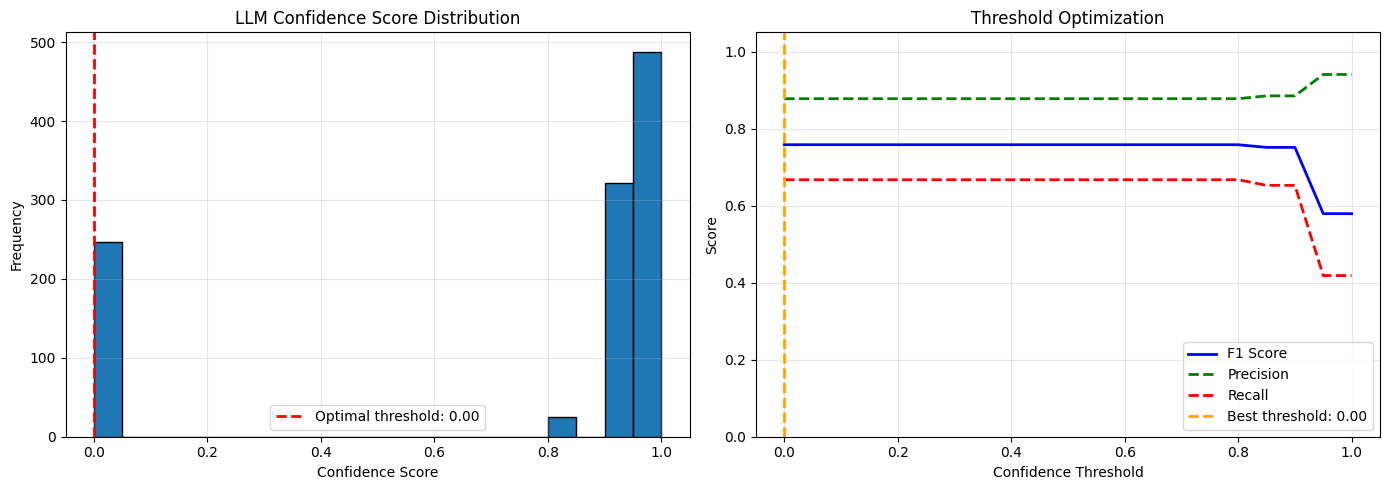


📊 Saved visualization to 'improved_llm_analysis.png'


In [48]:
if OPENAI_API_KEY and 'details_df' in locals():
    import matplotlib.pyplot as plt
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Confidence distribution
    ax1 = axes[0]
    details_df['confidence'].hist(bins=20, ax=ax1, edgecolor='black')
    ax1.axvline(best_threshold, color='red', linestyle='--', linewidth=2, label=f'Optimal threshold: {best_threshold:.2f}')
    ax1.set_xlabel('Confidence Score')
    ax1.set_ylabel('Frequency')
    ax1.set_title('LLM Confidence Score Distribution')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Threshold vs F1
    ax2 = axes[1]
    threshold_results = optimization_results['threshold_results']
    ax2.plot(threshold_results['threshold'], threshold_results['f1'], 'b-', linewidth=2, label='F1 Score')
    ax2.plot(threshold_results['threshold'], threshold_results['precision'], 'g--', linewidth=2, label='Precision')
    ax2.plot(threshold_results['threshold'], threshold_results['recall'], 'r--', linewidth=2, label='Recall')
    ax2.axvline(best_threshold, color='orange', linestyle='--', linewidth=2, label=f'Best threshold: {best_threshold:.2f}')
    ax2.set_xlabel('Confidence Threshold')
    ax2.set_ylabel('Score')
    ax2.set_title('Threshold Optimization')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    ax2.set_ylim([0, 1.05])
    
    plt.tight_layout()
    plt.savefig('improved_llm_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("\n📊 Saved visualization to 'improved_llm_analysis.png'")

## Analysis: What Made the Difference?

In [49]:
if OPENAI_API_KEY and 'details_df' in locals():
    print("\n" + "="*80)
    print("🔍 DETAILED ANALYSIS: WHAT MADE THE DIFFERENCE?")
    print("="*80)
    
    # Analyze confidence scores
    matched_confidences = details_df[details_df['matched_id_b'].notna()]['confidence']
    
    print("\nCONFIDENCE STATISTICS:")
    print(f"  Total queries: {len(details_df)}")
    print(f"  Found candidates: {matched_confidences.count()} ({matched_confidences.count()/len(details_df)*100:.1f}%)")
    print(f"  Mean confidence: {matched_confidences.mean():.3f}")
    print(f"  Median confidence: {matched_confidences.median():.3f}")
    print(f"  Std confidence: {matched_confidences.std():.3f}")
    
    # Confidence ranges
    print("\nCONFIDENCE RANGES:")
    ranges = [(0.0, 0.3), (0.3, 0.5), (0.5, 0.7), (0.7, 0.9), (0.9, 1.0)]
    for low, high in ranges:
        count = ((matched_confidences >= low) & (matched_confidences < high)).sum()
        pct = count / matched_confidences.count() * 100 if matched_confidences.count() > 0 else 0
        print(f"  [{low:.1f}, {high:.1f}): {count:4d} matches ({pct:5.1f}%)")
    
    # Sample high confidence matches
    print("\n" + "="*80)
    print("📋 SAMPLE HIGH-CONFIDENCE MATCHES (confidence >= 0.9):")
    print("="*80)
    high_conf = details_df[details_df['confidence'] >= 0.9].head(5)
    for idx, row in high_conf.iterrows():
        print(f"\nQuery: {row['text_a']}")
        print(f"Match: {row['matched_id_b']} (confidence: {row['confidence']:.2f})")
        print(f"Reasoning: {row['reasoning']}")
    
    # Sample low confidence / no match
    print("\n" + "="*80)
    print("📋 SAMPLE LOW-CONFIDENCE / NO MATCHES (confidence < 0.3):")
    print("="*80)
    low_conf = details_df[details_df['confidence'] < 0.3].head(5)
    for idx, row in low_conf.iterrows():
        print(f"\nQuery: {row['text_a']}")
        print(f"Match: {row['matched_id_b']} (confidence: {row['confidence']:.2f})")
        print(f"Reasoning: {row['reasoning']}")


🔍 DETAILED ANALYSIS: WHAT MADE THE DIFFERENCE?

CONFIDENCE STATISTICS:
  Total queries: 1081
  Found candidates: 834 (77.2%)
  Mean confidence: 0.956
  Median confidence: 1.000
  Std confidence: 0.055

CONFIDENCE RANGES:
  [0.0, 0.3):    0 matches (  0.0%)
  [0.3, 0.5):    0 matches (  0.0%)
  [0.5, 0.7):    0 matches (  0.0%)
  [0.7, 0.9):   25 matches (  3.0%)
  [0.9, 1.0):  321 matches ( 38.5%)

📋 SAMPLE HIGH-CONFIDENCE MATCHES (confidence >= 0.9):

Query: bose acoustimass 5 series iii speaker system - am53bk bose acoustimass 5 series iii speaker system -...
Match: 202812620 (confidence: 0.90)
Reasoning: The candidate record [1] describes the "bose acoustimass 5 series iii speaker system" which matches the query record's core product identity. Both records refer to the same model, and while the candid

Query: sony switcher - sbv40s sony switcher - sbv40s/ eliminates disconnecting and reconnecting cables/ com...
Match: 90049928 (confidence: 1.00)
Reasoning: The candidate record desc

## Optional: Run on Ciphered and Scrambled Datasets

**Note:** This will cost additional money (~$0.25 per dataset). Only run if you want complete comparison.

In [ ]:
# Run improved LLM on ciphered dataset
 if OPENAI_API_KEY:
     print("\n🔐 Running improved LLM on CIPHERED dataset...")
     
     predicted_cipher, cost_cipher, details_cipher = llm_matching_improved(
         df_abt_ciphered, df_buy_ciphered, 'id', 'id', client,
         confidence_threshold=best_threshold,  # Use same threshold
         top_k=20, blocking_threshold=0.1, max_text_length=500,
         save_details=False
     )
    
     metrics_cipher = calculate_metrics(
         predicted_cipher, true_matches_ciphered, 
         len(df_abt_ciphered) * len(df_buy_ciphered)
     )
     
     print(f"\nCiphered Results: F1={metrics_cipher['f1']:.3f}, Cost=${cost_cipher:.3f}")

# Run improved LLM on scrambled dataset  
 if OPENAI_API_KEY:
     print("\n🔀 Running improved LLM on SCRAMBLED dataset...")
     
     predicted_scrambled, cost_scrambled, details_scrambled = llm_matching_improved(
         df_abt_scrambled, df_buy_scrambled, 'id', 'id', client,
         confidence_threshold=best_threshold,
         top_k=20, blocking_threshold=0.1, max_text_length=500,
         save_details=False
     )
     
     metrics_scrambled = calculate_metrics(
         predicted_scrambled, true_matches_scrambled,
         len(df_abt_scrambled) * len(df_buy_scrambled)
     )
     
     print(f"\nScrambled Results: F1={metrics_scrambled['f1']:.3f}, Cost=${cost_scrambled:.3f}")